In [3]:
# pip install matplotlib open3d numpy torch pyquaternion pandas

download mini dataset

In [ ]:
# !mkdir -p nuscenes  # Make the directory

# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

# !tar -xf v1.0-mini.tgz -C nuscenes  # Uncompress

# !pip install nuscenes-devkit 

download pytorch version

In [ ]:
# ! git clone https://github.com/basantiroomie/Pointnet_Pointnet2_pytorch.git

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from Pointnet_Pointnet2_pytorch.models.pointnet_utils import PointNetEncoder, feature_transform_reguliarzer
import open3d as o3d
from pyquaternion import Quaternion  # Add this import
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cpu


In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.764 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## A look at the dataset

In [27]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [28]:
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [3]:
sample = nusc.sample[0]

lidar_token = sample['data']['LIDAR_TOP']
lidar_data = nusc.get('sample_data', lidar_token)

lidar_file = f"{nusc.dataroot}/{lidar_data['filename']}"
print("LIDAR file path:", lidar_file)


LIDAR file path: v1.0-mini/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin


In [4]:
points = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 5)  # x, y, z, intensity, ring index
print("Point Cloud Shape:", points.shape)  # Each row: [x, y, z, intensity, ring_index]


Point Cloud Shape: (34688, 5)


### 3D Point Cloud Visualization

In [6]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:, :3]) 
o3d.visualization.draw_geometries([pcd])


### 2D Projections of 3D Point Cloud

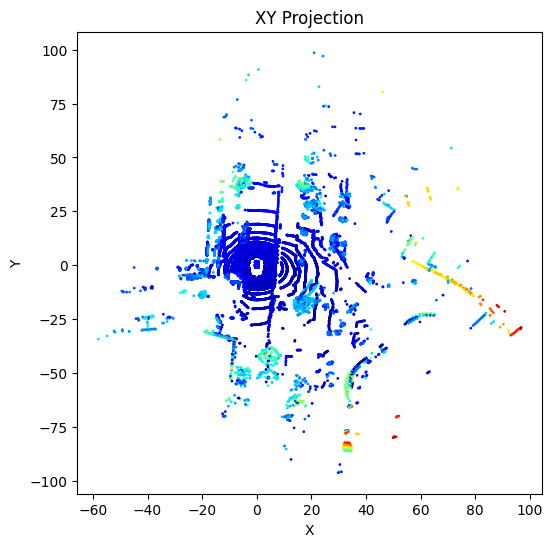

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# XY Projection (only x and y axes)
ax.scatter(points[:, 0], points[:, 1], s=1, c=points[:, 2], cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('XY Projection')
plt.show()


### visibility
visibility is defined as the fraction of pixels of a particular annotation that are visible over the 6 camera feeds, grouped into 4 bins.

In [30]:
nusc.visibility

[{'description': 'visibility of whole object is between 0 and 40%',
  'token': '1',
  'level': 'v0-40'},
 {'description': 'visibility of whole object is between 40 and 60%',
  'token': '2',
  'level': 'v40-60'},
 {'description': 'visibility of whole object is between 60 and 80%',
  'token': '3',
  'level': 'v60-80'},
 {'description': 'visibility of whole object is between 80 and 100%',
  'token': '4',
  'level': 'v80-100'}]

Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}


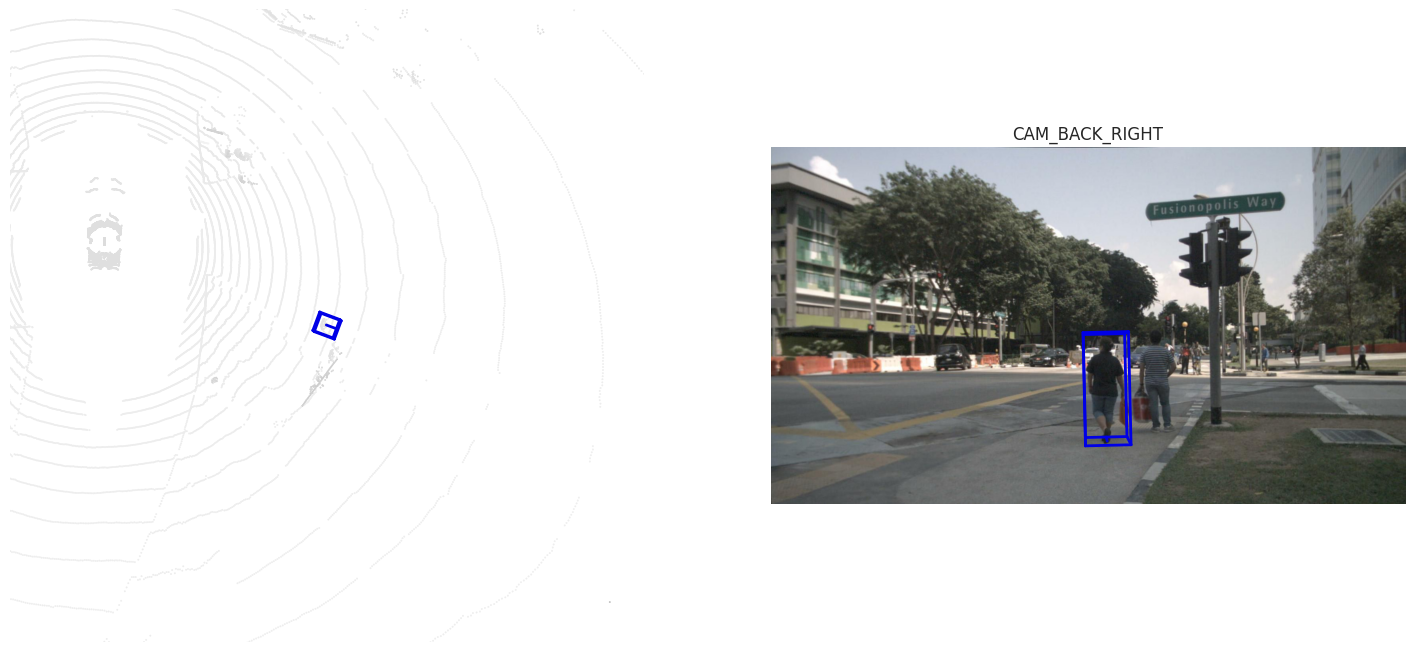

In [31]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}


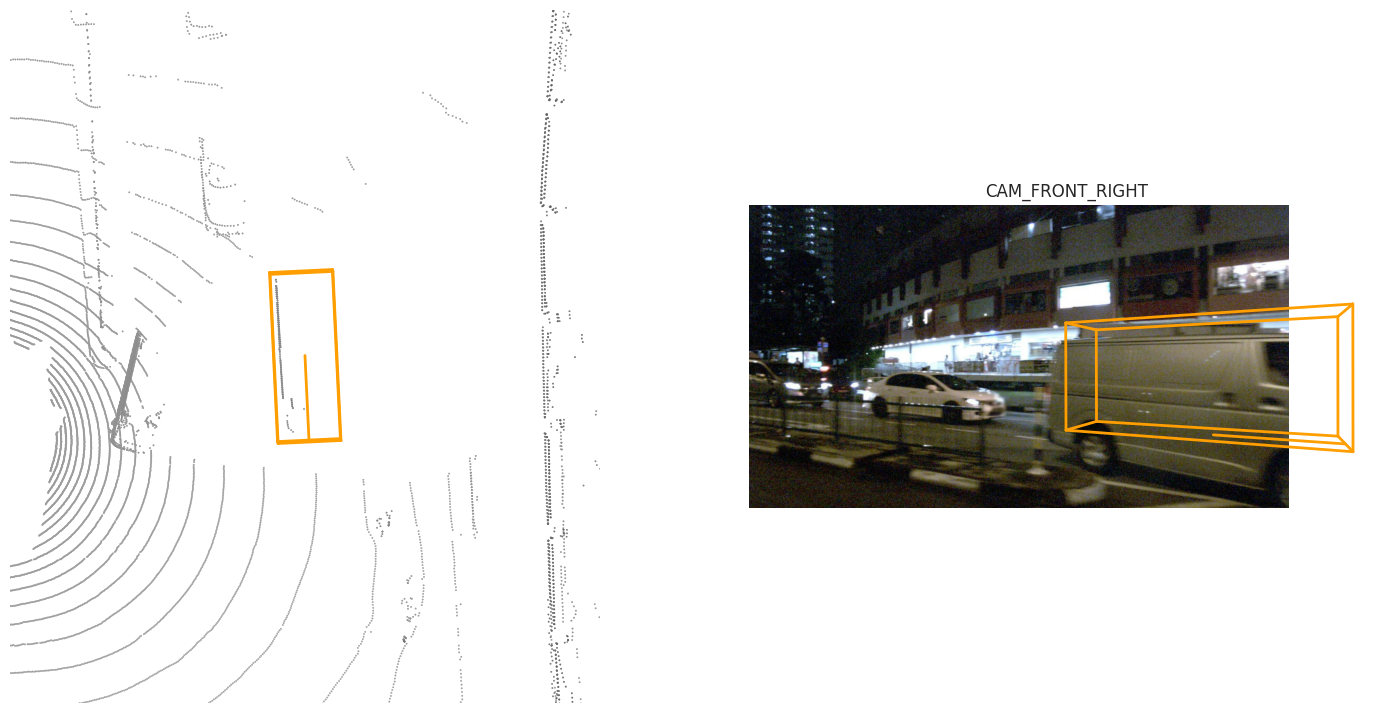

In [32]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

### Render
First, let's plot a lidar point cloud in an image. Lidar allows us to accurately map the surroundings in 3D.

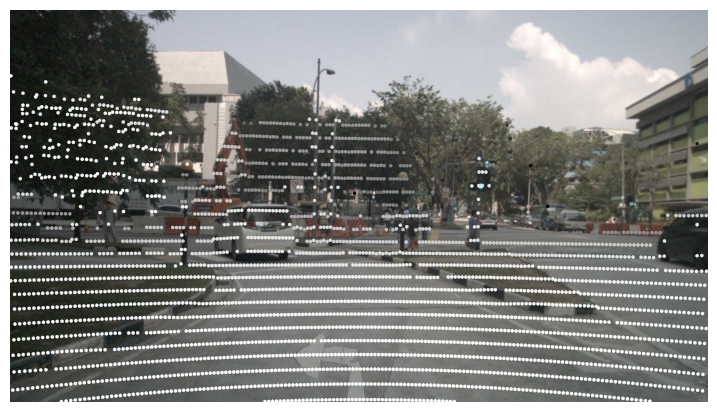

In [33]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

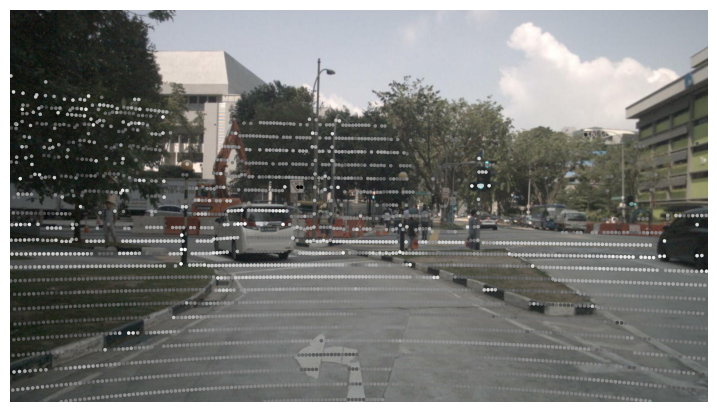

In [34]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP', render_intensity=True)

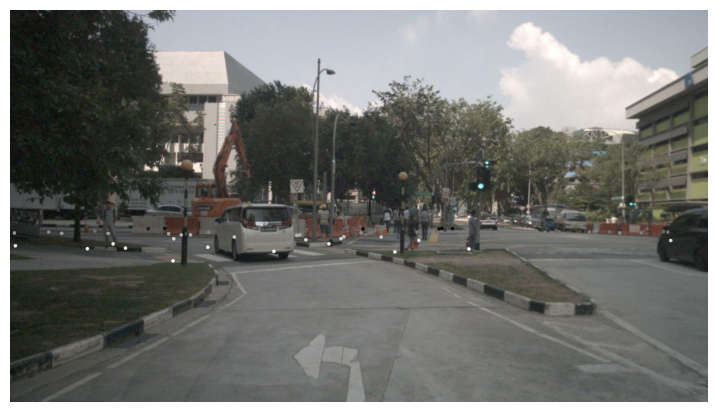

In [35]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

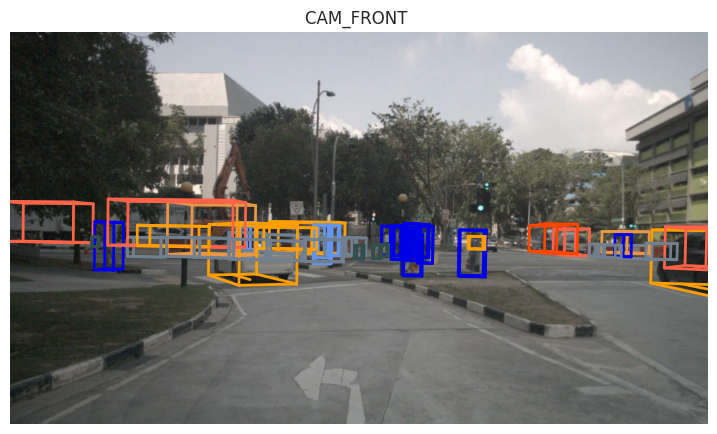

In [36]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

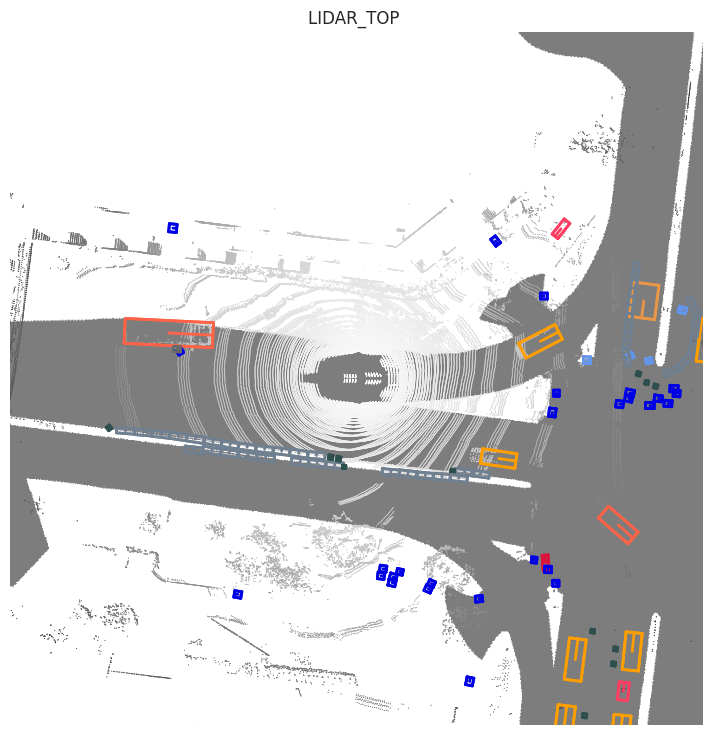

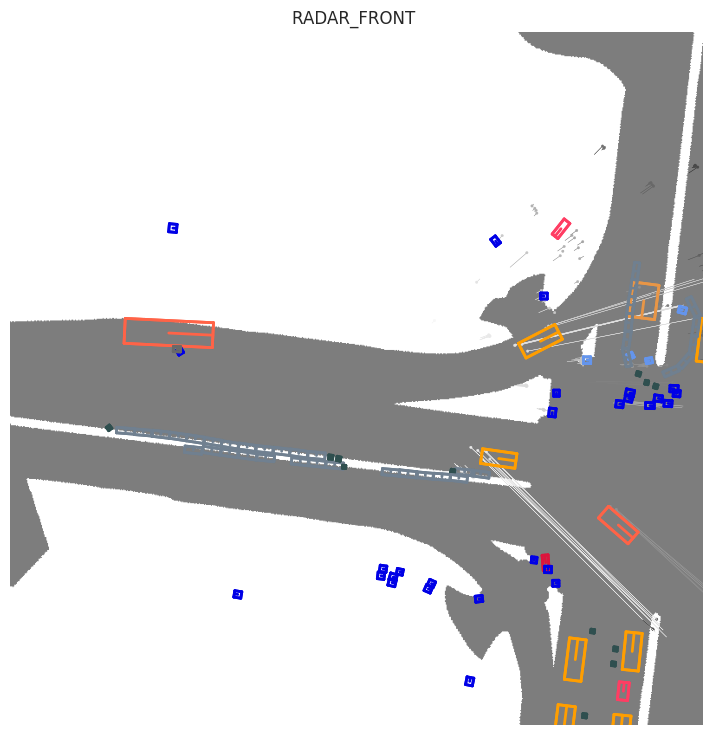

In [37]:
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=True)
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)

### Point Cloud Density Visualization

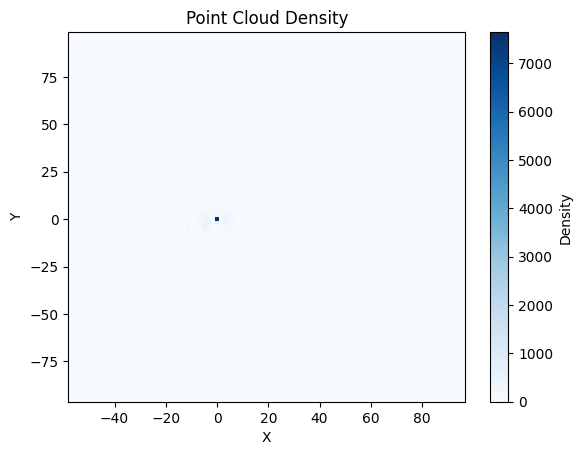

In [10]:
plt.hist2d(points[:, 0], points[:, 1], bins=100, cmap='Blues')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Cloud Density')
plt.show()


### Point Cloud and Bounding Boxes

In [52]:
def visualize_pointcloud_with_boxes(nusc, sample_lidar_token):
    # Get point cloud data
    lidar_data = nusc.get('sample_data', sample_lidar_token)
    pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, lidar_data['filename']))
    points = pc.points.T[:, :3]
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.paint_uniform_color([0.6, 0.6, 0.6])  # Gray color for points
    
    # Create bounding boxes for annotations
    geometries = [pcd]
    sample = nusc.get('sample', lidar_data['sample_token'])
    for ann_token in sample['anns']:
        ann = nusc.get('sample_annotation', ann_token)
        # Create box with center, size and rotation
        center = np.array(ann['translation'])
        size = np.array(ann['size'])
        # Create quaternion from the rotation values
        quat = Quaternion(ann['rotation'])
        box = o3d.geometry.OrientedBoundingBox(
            center=center,
            R=np.array(quat.rotation_matrix),
            extent=size
        )
        box.color = np.array([1, 0, 0])  # Red color for boxes
        geometries.append(box)
    
    # Visualize
    o3d.visualization.draw_geometries(geometries)

sample_lidar_token = nusc.sample[0]['data']['LIDAR_TOP']  # Get first sample
visualize_pointcloud_with_boxes(nusc, sample_lidar_token)

### Trajectory of Vehicles (Ego Movement)

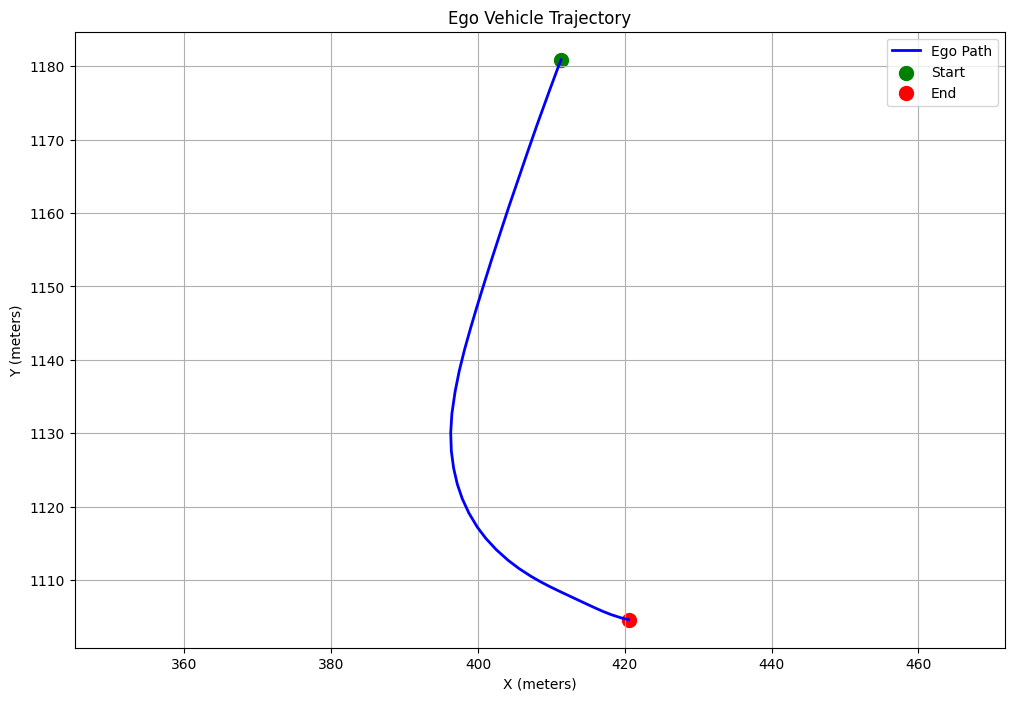

In [13]:
def plot_ego_trajectory(nusc, scene_idx=0):
    scene = nusc.scene[scene_idx]
    sample_token = scene['first_sample_token']
    
    trajectory = []
    while sample_token:
        sample = nusc.get('sample', sample_token)
        pose = nusc.get('ego_pose', sample['data']['LIDAR_TOP'])
        trajectory.append(pose['translation'][:2])  # Only X and Y coordinates
        sample_token = sample['next']
    
    trajectory = np.array(trajectory)
    
    plt.figure(figsize=(12, 8))
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Ego Path')
    plt.scatter(trajectory[0, 0], trajectory[0, 1], c='g', s=100, label='Start')
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='r', s=100, label='End')
    
    plt.title('Ego Vehicle Trajectory')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Usage
plot_ego_trajectory(nusc)

In [3]:
nusc.render_egoposes_on_map(log_location='singapore-onenorth')

Adding ego poses to map...


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Creating plot...


: 

this is supposed to be the output but the kernel is crashing

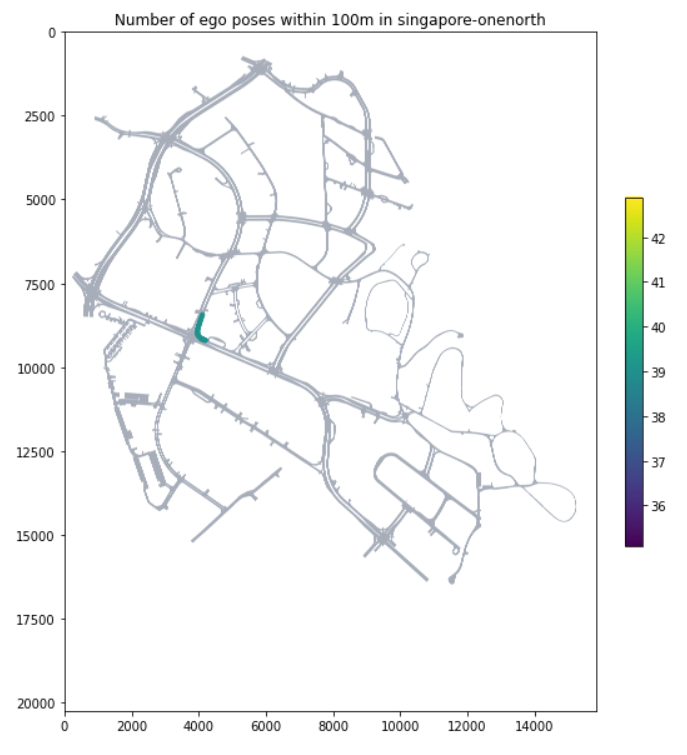

### Label Distribution Histogram

Unique labels: {'static_object.bicycle_rack', 'vehicle.car', 'vehicle.bus.rigid', 'vehicle.trailer', 'movable_object.barrier', 'human.pedestrian.police_officer', 'vehicle.construction', 'human.pedestrian.construction_worker', 'human.pedestrian.adult', 'human.pedestrian.personal_mobility', 'vehicle.bus.bendy', 'movable_object.trafficcone', 'movable_object.pushable_pullable', 'vehicle.bicycle', 'human.pedestrian.child', 'movable_object.debris', 'vehicle.truck', 'vehicle.motorcycle'}


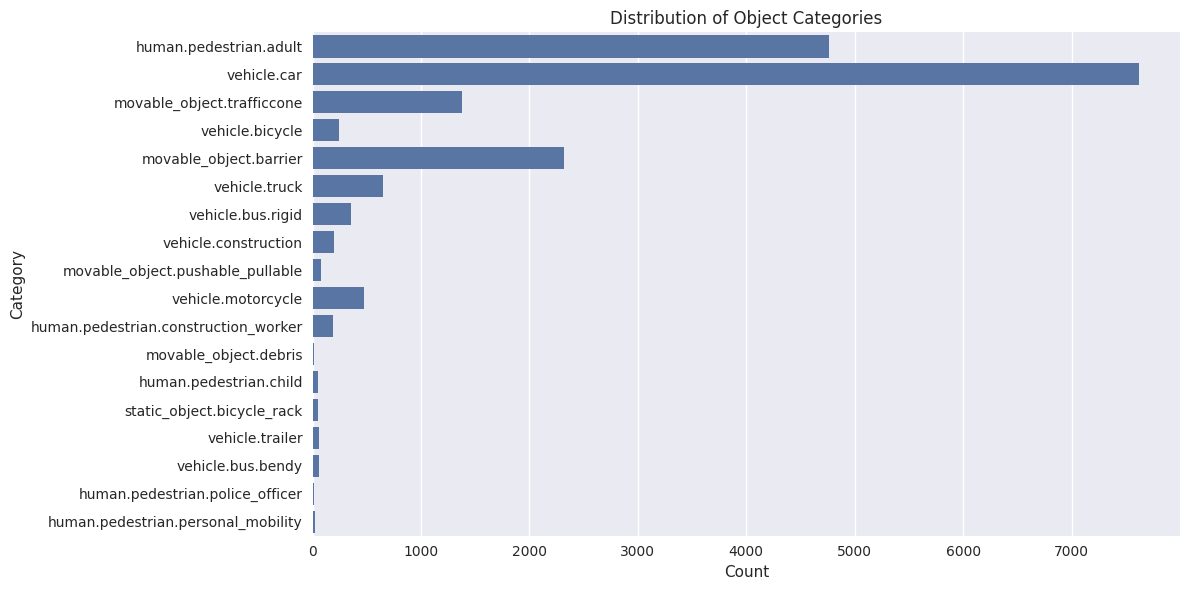

In [65]:
def plot_label_distribution(nusc):
    labels = []
    for scene in nusc.scene:
        sample_token = scene['first_sample_token']
        while sample_token:
            sample = nusc.get('sample', sample_token)
            for ann_token in sample['anns']:
                ann = nusc.get('sample_annotation', ann_token)
                labels.append(ann['category_name'])
            sample_token = sample['next']
    
    df = pd.DataFrame({'category': labels})
    
    unique_labels = set(labels)
    print("Unique labels:", unique_labels)

    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, y='category')
    plt.title('Distribution of Object Categories')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()

# Usage
plot_label_distribution(nusc)

### 3D visualization of specific classes

In [57]:
label_to_class = {
    0: 'human.pedestrian.police_officer',
    1: 'movable_object.trafficcone',
    2: 'vehicle.construction',
    3: 'vehicle.bicycle',
    4: 'vehicle.car',
    5: 'vehicle.trailer',
    6: 'movable_object.barrier',
    7: 'human.pedestrian.construction_worker',
    8: 'movable_object.pushable_pullable',
    9: 'vehicle.bus.rigid',
    10: 'human.pedestrian.adult',
    11: 'vehicle.motorcycle',
    12: 'human.pedestrian.child',
    13: 'vehicle.bus.bendy',
    14: 'vehicle.truck',
    15: 'movable_object.debris',
    16: 'static_object.bicycle_rack'
}

labels_of_interest = {'vehicle.car'}

numeric_labels_of_interest = [key for key, value in label_to_class.items() if value in labels_of_interest]
print("Unique labels in the dataset:", np.unique(points[:, 3]))
filtered_points = points[np.isin(points[:, 3], numeric_labels_of_interest)]  # Filter by numeric label

if filtered_points.shape[0] == 0:
    print("No points found with the specified labels.")
else:
    print(f"Filtered {filtered_points.shape[0]} points.")

filtered_points_xyz = filtered_points[:, :3]

if filtered_points_xyz.shape[0] == 0:
    print("No filtered points to visualize.")
else:
    pcd_filtered = o3d.geometry.PointCloud()
    pcd_filtered.points = o3d.utility.Vector3dVector(filtered_points_xyz)

    o3d.visualization.draw_geometries([pcd_filtered])


Unique labels in the dataset: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 117. 118. 119. 120. 121. 122. 123. 124. 127. 128.
 129. 130. 132. 135. 136. 137. 138. 139. 140. 142. 144. 146. 147. 148.
 151. 153. 155. 156. 164. 165. 169. 172. 181. 193. 194. 209. 216. 219.
 220. 222. 226. 230. 231. 234. 235. 239. 241. 249. 251. 255.]
Filtered 1907 points.


# Traffic Density prediction

In [5]:
NUM_CLASSES=5
class PointNetCls(nn.Module):
    def __init__(self, k=NUM_CLASSES, normal_channel=True):
        super(PointNetCls, self).__init__()
        if normal_channel:
            channel = 6
        else:
            channel = 3
        self.feat = PointNetEncoder(global_feat=True, feature_transform=True, channel=channel)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.k = k 

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x, trans, trans_feat
    
class PointNetLoss(nn.Module):
    def __init__(self, mat_diff_loss_scale=0.001):
        super(PointNetLoss, self).__init__()
        self.mat_diff_loss_scale = mat_diff_loss_scale

    def forward(self, pred, target, trans_feat):
        loss = F.nll_loss(pred, target)
        mat_diff_loss = feature_transform_reguliarzer(trans_feat)
        total_loss = loss + mat_diff_loss * self.mat_diff_loss_scale
        return total_loss


In [6]:
class NuScenesTrafficDataset(Dataset):
    def __init__(self, nusc, split='train', num_points=2048, normal_channel=True):
        self.nusc = nusc
        self.split = split
        self.num_points = num_points
        self.normal_channel = normal_channel
        self.scene_tokens = [s['token'] for s in nusc.scene]
        self.lidar_tokens = []
        
        for scene_token in self.scene_tokens:
            scene = nusc.get('scene', scene_token)
            sample_token = scene['first_sample_token']
            
            while sample_token:
                sample = nusc.get('sample', sample_token)
                lidar_token = sample['data']['LIDAR_TOP']
                self.lidar_tokens.append(lidar_token)
                sample_token = sample['next']

    def __len__(self):
        return len(self.lidar_tokens)

    def get_traffic_density(self, points):
        AREA_SIZE = 100 * 100
        
        # Filter ground points (assuming z-axis is vertical)
        # Only consider points between 0.1m and 3m height to focus on vehicles
        vehicle_points = points[(points[:, 2] >= 0.1) & (points[:, 2] <= 3.0)]
        
        point_density = len(vehicle_points) / AREA_SIZE

        if point_density < 0.2:
            return 0    # Very Low Traffic
        elif point_density < 0.3:
            return 1    # Low Traffic
        elif point_density < 0.4:
            return 2    # Medium Traffic
        elif point_density < 0.5:
            return 3    # High Traffic
        else:
            return 4    # Very High Traffic
        
    def __getitem__(self, idx):
        lidar_token = self.lidar_tokens[idx]
        lidar_data = self.nusc.get('sample_data', lidar_token)
        pcl_path = os.path.join(self.nusc.dataroot, lidar_data['filename'])

        pc = LidarPointCloud.from_file(pcl_path)
        points = pc.points.T

        label = self.get_traffic_density(points)

        points = points[:, :3]

        if len(points) > self.num_points:
            choice = np.random.choice(len(points), self.num_points, replace=False)
        else:
            choice = np.random.choice(len(points), self.num_points, replace=True)
        points = points[choice, :]

        points = points - np.mean(points, axis=0)
        dist = np.max(np.sqrt(np.sum(points ** 2, axis=1)))
        points = points / dist
        
        if self.normal_channel:
            normals = np.zeros((self.num_points, 3))
            points = np.concatenate([points, normals], axis=1)
        
        points = torch.FloatTensor(points)
        label = torch.LongTensor([label])
        
        return points.transpose(1, 0), label.squeeze()


In [7]:
training_losses = []
training_accuracies = []

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    batch_losses = []
    
    for i, (points, target) in enumerate(dataloader):
        assert torch.all(target < model.k), f"Invalid target values found: {target.unique()}"
        points, target = points.to(device), target.to(device)
        
        optimizer.zero_grad()
        pred, trans, trans_feat = model(points)
        loss = criterion(pred, target, trans_feat)
        
        loss.backward()
        optimizer.step()
        
        pred_choice = pred.max(1)[1]
        correct += pred_choice.eq(target.data).cpu().sum()
        total += points.size(0)
        total_loss += loss.item()
        batch_losses.append(loss.item())
        
        if i % 10 == 0:
            print(f'Batch [{i}/{len(dataloader)}] Loss: {loss.item():.4f}')
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, accuracy, batch_losses

In [8]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for points, target in dataloader:
            points, target = points.to(device), target.to(device)
            pred, _, _ = model(points)
            pred_choice = pred.max(1)[1]
            
            predictions.extend(pred_choice.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # Calculate overall accuracy
    overall_accuracy = (predictions == targets).mean()
    
    # Calculate per-class accuracies
    class_accuracies = []
    for class_idx in range(model.k):
        mask = targets == class_idx
        if mask.sum() > 0:
            class_acc = (predictions[mask] == targets[mask]).mean()
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0.0)
    
    return overall_accuracy, class_accuracies

In [17]:
def main():
    global model, dataloader
    BATCH_SIZE = 8
    NUM_POINTS = 2048
    NORMAL_CHANNEL = True
    NUM_EPOCHS = 25
    LEARNING_RATE = 0.0001

    dataset = NuScenesTrafficDataset(nusc, num_points=NUM_POINTS, normal_channel=NORMAL_CHANNEL)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    model = PointNetCls(k=NUM_CLASSES, normal_channel=NORMAL_CHANNEL).to(device)
    criterion = PointNetLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_accuracy = 0
    training_losses = []
    training_accuracies = []
    
    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        
        avg_loss, accuracy, batch_losses = train_epoch(model, dataloader, criterion, optimizer, device)
        scheduler.step()

        training_losses.append(avg_loss)
        training_accuracies.append(accuracy)
        
        print(f'Average loss: {avg_loss:.4f}')
        print(f'Accuracy: {accuracy:.2f}%')

        with open('training_metrics.txt', 'w') as f:
            for epoch_idx, (loss, acc) in enumerate(zip(training_losses, training_accuracies)):
                f.write(f"Epoch {epoch_idx+1}, Loss: {loss:.4f}, Accuracy: {acc:.2f}%\n")

    print("\nTraining completed. Evaluating best model...")
    
if __name__ == "__main__":
    main()

Starting training...
Epoch 1/25
Batch [0/51] Loss: 1.5223
Batch [10/51] Loss: 1.7173
Batch [20/51] Loss: 1.6924
Batch [30/51] Loss: 1.5433
Batch [40/51] Loss: 1.7972
Batch [50/51] Loss: 1.6020
Average loss: 1.6205
Accuracy: 38.12%
Epoch 2/25
Batch [0/51] Loss: 1.3672
Batch [10/51] Loss: 1.1850
Batch [20/51] Loss: 1.3589
Batch [30/51] Loss: 1.4315
Batch [40/51] Loss: 1.2700
Batch [50/51] Loss: 1.6874
Average loss: 1.3739
Accuracy: 56.19%
Epoch 3/25
Batch [0/51] Loss: 1.5808
Batch [10/51] Loss: 1.2765
Batch [20/51] Loss: 1.3383
Batch [30/51] Loss: 1.1618
Batch [40/51] Loss: 0.9512
Batch [50/51] Loss: 0.8377
Average loss: 1.2005
Accuracy: 61.39%
Epoch 4/25
Batch [0/51] Loss: 1.1905
Batch [10/51] Loss: 1.2284
Batch [20/51] Loss: 1.0926
Batch [30/51] Loss: 1.1128
Batch [40/51] Loss: 1.0266
Batch [50/51] Loss: 1.4670
Average loss: 1.0874
Accuracy: 64.36%
Epoch 5/25
Batch [0/51] Loss: 0.9941
Batch [10/51] Loss: 0.7514
Batch [20/51] Loss: 1.5716
Batch [30/51] Loss: 1.2523
Batch [40/51] Loss: 1

In [18]:
epochs, losses, accuracies = [], [], []
with open('training_metrics.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        epoch = int(parts[0].split()[-1])
        loss = float(parts[1].split()[-1])
        accuracy = float(parts[2].split()[-1].rstrip('%'))
        
        epochs.append(epoch)
        losses.append(loss)
        accuracies.append(accuracy)

print(f"Final Loss: {losses[-1]:.4f}")
print(f"Final Accuracy: {accuracies[-1]:.2f}%")
print(f"Best Accuracy: {max(accuracies):.2f}%")
print(f"Lowest Loss: {min(losses):.4f}")

Final Loss: 0.6305
Final Accuracy: 80.94%
Best Accuracy: 81.44%
Lowest Loss: 0.6305


### train loss and accuracy

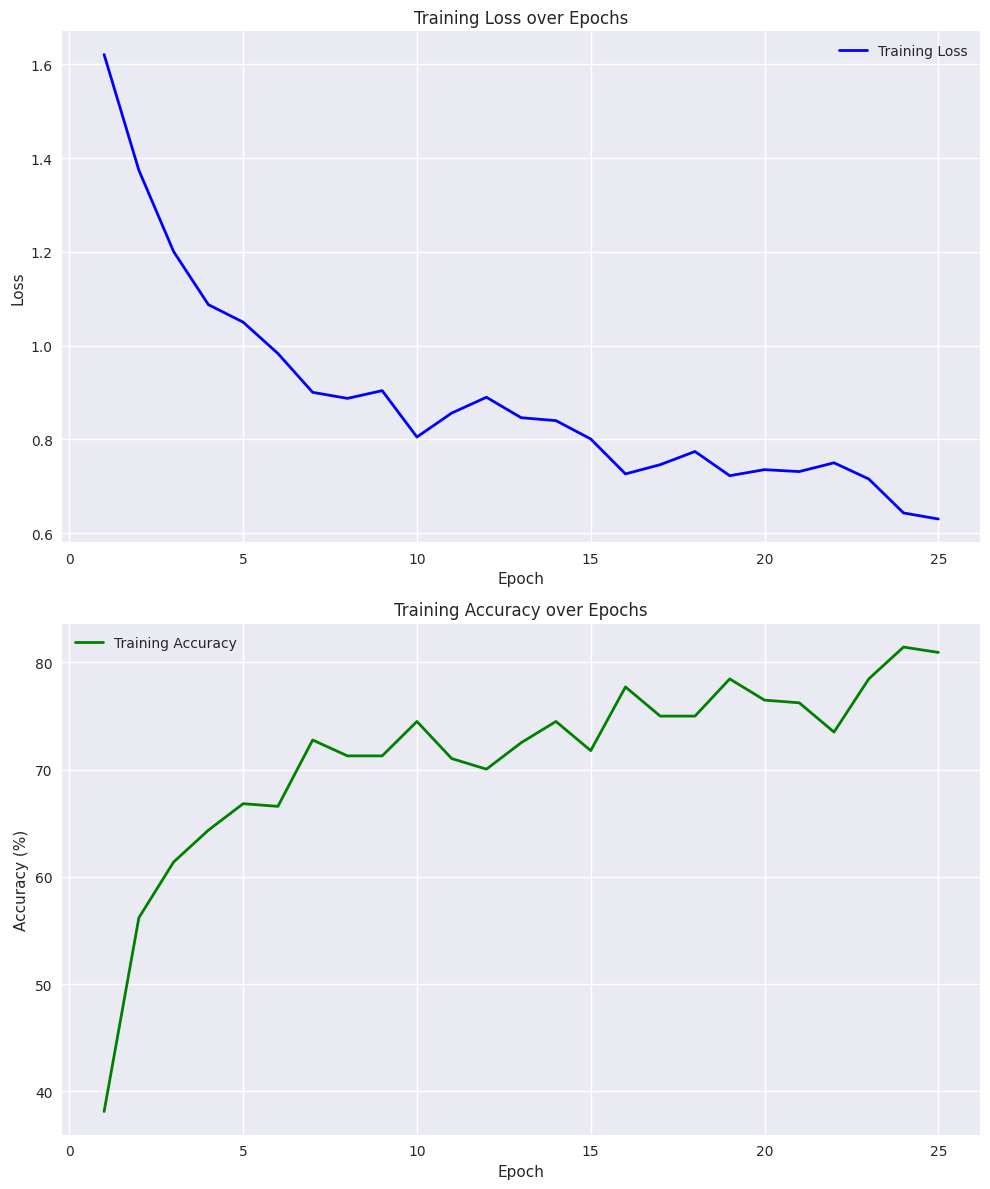

In [19]:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(epochs, losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True)
ax1.legend()

ax2.plot(epochs, accuracies, 'g-', linewidth=2, label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy over Epochs')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix for Classification

In [20]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []


Number of true labels: 404
Number of predicted labels: 404


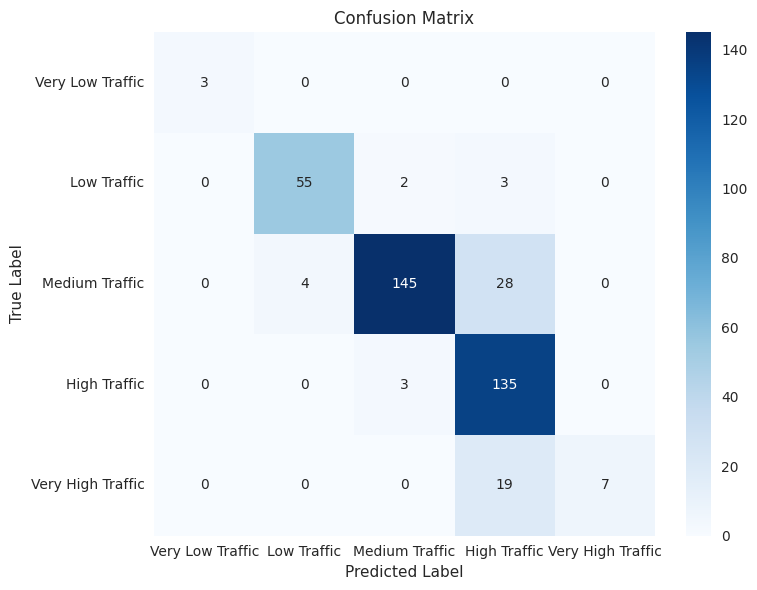

In [21]:
class_names = ['Very Low Traffic', 'Low Traffic', 'Medium Traffic', 'High Traffic', 'Very High Traffic']

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for points, target in dataloader:
        points, target = points.to(device), target.to(device)
        pred, _, _ = model(points)
        pred_choice = pred.max(1)[1]
        
        all_preds.extend(pred_choice.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

print(f"Number of true labels: {len(all_labels)}")
print(f"Number of predicted labels: {len(all_preds)}")

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [22]:
print("True labels:", all_labels[:10])
print("Predicted labels:", all_preds[:10])
print("Unique true labels:", np.unique(all_labels))
print("Unique predicted labels:", np.unique(all_preds))

True labels: [3, 3, 1, 2, 2, 1, 2, 3, 3, 3]
Predicted labels: [3, 3, 2, 2, 3, 1, 2, 3, 3, 3]
Unique true labels: [0 1 2 3 4]
Unique predicted labels: [0 1 2 3 4]


In [23]:
print("Number of true labels:", len(all_labels))
print("Number of predicted labels:", len(all_preds))

Number of true labels: 404
Number of predicted labels: 404


### Object-wise Precision, Recall, and F1-Score

In [24]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds)

for i, label in enumerate(class_names):
    print(f"Class: {label}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1 Score: {f1[i]:.4f}")
    print("-" * 30)


Class: Very Low Traffic
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------
Class: Low Traffic
Precision: 0.9322
Recall: 0.9167
F1 Score: 0.9244
------------------------------
Class: Medium Traffic
Precision: 0.9667
Recall: 0.8192
F1 Score: 0.8869
------------------------------
Class: High Traffic
Precision: 0.7297
Recall: 0.9783
F1 Score: 0.8359
------------------------------
Class: Very High Traffic
Precision: 1.0000
Recall: 0.2692
F1 Score: 0.4242
------------------------------


# Emergency Vehicle

In [29]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
import torch.nn.functional as F
import logging
from sklearn.metrics import classification_report
import re
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [30]:
class EmergencyVehicleDataset(Dataset):
    def __init__(self, nusc, split='train'):
        self.nusc = nusc
        self.split = split
        self.samples = self._get_vehicle_samples()
        logging.info(f"Initialized dataset with {len(self.samples)} samples")
    
    def _get_vehicle_samples(self):
        samples = []
        for sample in self.nusc.sample:
            anns = [self.nusc.get('sample_annotation', token) for token in sample['anns']]
            vehicle_anns = [ann for ann in anns if ann['category_name'].startswith('vehicle')]
            if vehicle_anns:
                samples.append({
                    'sample': sample,
                    'annotations': vehicle_anns
                })
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample_data = self.samples[idx]
        
        # Get LiDAR point cloud
        lidar_token = sample_data['sample']['data']['LIDAR_TOP']
        lidar_data = self.nusc.get('sample_data', lidar_token)
        pc = LidarPointCloud.from_file(os.path.join(self.nusc.dataroot, lidar_data['filename']))
        
        # Process point cloud - now only taking x, y, z coordinates
        points = self._process_pointcloud(pc.points.T[:, :3])  # Only take first 3 channels
        
        # Create label
        is_emergency = any(self._is_emergency_vehicle(ann) for ann in sample_data['annotations'])
        label = torch.tensor(1 if is_emergency else 0, dtype=torch.long)
        
        return points, label
    
    def _process_pointcloud(self, points):
        """Process point cloud for model input"""
        # Ensure we have the correct number of points
        if len(points) > 1024:
            idx = np.random.choice(len(points), 1024, replace=False)
            points = points[idx]
        elif len(points) < 1024:
            idx = np.random.choice(len(points), 1024, replace=True)
            points = points[idx]
        
        # Normalize points
        centroid = np.mean(points[:, :3], axis=0)
        points[:, :3] -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(points[:, :3]**2, axis=1)))
        points[:, :3] /= furthest_distance
        
        return torch.FloatTensor(points)
    
    def _is_emergency_vehicle(self, annotation):
        emergency_categories = ['vehicle.emergency.ambulance', 'vehicle.emergency.police']
        return annotation['category_name'] in emergency_categories


In [31]:
class PointNetFeatures(nn.Module):
    def __init__(self):
        super(PointNetFeatures, self).__init__()
        # Input channels is now explicitly 3 (x, y, z)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
    def forward(self, x):
        # Add shape validation
        if x.shape[1] != 3:
            raise ValueError(f"Expected input to have 3 channels, got {x.shape[1]} channels")
            
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        return x


In [32]:
class EmergencyVehicleDetector(nn.Module):
    def __init__(self):
        super(EmergencyVehicleDetector, self).__init__()
        self.features = PointNetFeatures()
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        try:
            x = self.features(x.transpose(2, 1))  # [batch_size, 3, num_points]
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.dropout(x)
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.dropout(x)
            x = self.fc3(x)
            return x
        except Exception as e:
            logging.error(f"Error in forward pass: {str(e)}")
            raise


In [33]:
def train_model(model, train_loader, val_loader, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    best_val_acc = 0.0
    training_metrics = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_confusion_matrix = np.zeros((2, 2))
        
        for batch_idx, (points, labels) in enumerate(train_loader):
            try:
                points, labels = points.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(points)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
                
                if batch_idx % 10 == 0:
                    logging.info(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] '
                               f'Loss: {loss.item():.4f}')
                for t, p in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                    train_confusion_matrix[t][p] += 1

            except Exception as e:
                logging.error(f"Error in training batch {batch_idx}: {str(e)}")
                continue
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_confusion_matrix = np.zeros((2, 2))
        
        with torch.no_grad():
            for points, labels in val_loader:
                try:
                    points, labels = points.to(device), labels.to(device)
                    outputs = model(points)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
                    for t, p in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                        val_confusion_matrix[t][p] += 1
                except Exception as e:
                    logging.error(f"Error in validation: {str(e)}")
                    continue
        
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        # Store metrics
        epoch_metrics = {
            'epoch': epoch + 1,
            'trainLoss': train_loss / len(train_loader),
            'valLoss': val_loss / len(val_loader),
            'trainAcc': train_acc,
            'valAcc': val_acc,
            'trainConfusionMatrix': train_confusion_matrix.tolist(),
            'valConfusionMatrix': val_confusion_matrix.tolist()
        }
        training_metrics.append(epoch_metrics)
        
        # Save metrics to file
        with open('training_metrics_emer.txt', 'a') as f:  # 'a' for appending
            f.write(f"epoch:{epoch+1}, "
                    f"trainLoss: {train_loss / len(train_loader):.4f}, "
                    f"valLoss: {val_loss / len(val_loader):.4f}, "
                    f"trainAccuracy: {train_acc:.2f}%, "
                    f"valAccuracy: {val_acc:.2f}%, "
                    f"trainConfusionMatrix: {train_confusion_matrix.tolist()}, "
                    f"valConfusionMatrix: {val_confusion_matrix.tolist()}\n")
            
            
        logging.info(f'Epoch [{epoch+1}/{num_epochs}]')
        logging.info(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        logging.info(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_emergency_vehicle_detector.pth')
            logging.info(f'Saved new best model with validation accuracy: {val_acc:.2f}%')
        
        scheduler.step()
        

In [34]:
def main():
    try:
        # Create datasets
        train_dataset = EmergencyVehicleDataset(nusc, split='train')
        val_dataset = EmergencyVehicleDataset(nusc, split='val')
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
        
        # Initialize model
        model = EmergencyVehicleDetector()
        
        # Train model
        train_model(model, train_loader, val_loader)
        
        # Evaluate model
        model.eval()
        all_true_labels = []
        all_predicted_labels = []
        with torch.no_grad():
            for points, labels in val_loader:
                points, labels = points.to(device), labels.to(device)
                outputs = model(points)
                _, predicted = outputs.max(1)
                all_true_labels.extend(labels.cpu().numpy())
                all_predicted_labels.extend(predicted.cpu().numpy())
        
        return all_true_labels, all_predicted_labels

    except Exception as e:
        logging.error(f"Error in main function: {str(e)}")
        raise

if __name__ == '__main__':
    all_true_labels, all_predicted_labels = main()


2024-12-27 23:08:33,611 - INFO - Initialized dataset with 404 samples
2024-12-27 23:08:33,627 - INFO - Initialized dataset with 404 samples
2024-12-27 23:08:33,642 - INFO - Using device: cpu
2024-12-27 23:08:34,071 - INFO - Epoch [1/5] Batch [0/26] Loss: 0.8898
2024-12-27 23:08:36,243 - INFO - Epoch [1/5] Batch [10/26] Loss: 0.1885
2024-12-27 23:08:38,437 - INFO - Epoch [1/5] Batch [20/26] Loss: 0.0463
2024-12-27 23:08:42,066 - INFO - Epoch [1/5]
2024-12-27 23:08:42,068 - INFO - Train Loss: 0.2600, Train Acc: 91.09%
2024-12-27 23:08:42,068 - INFO - Val Loss: 0.0014, Val Acc: 100.00%
2024-12-27 23:08:42,100 - INFO - Saved new best model with validation accuracy: 100.00%
2024-12-27 23:08:42,503 - INFO - Epoch [2/5] Batch [0/26] Loss: 0.0294
2024-12-27 23:08:44,570 - INFO - Epoch [2/5] Batch [10/26] Loss: 0.0149
2024-12-27 23:08:46,749 - INFO - Epoch [2/5] Batch [20/26] Loss: 0.0116
2024-12-27 23:08:49,742 - INFO - Epoch [2/5]
2024-12-27 23:08:49,743 - INFO - Train Loss: 0.0169, Train Acc

### Classification Report

In [48]:
CLASS_NAME =['Non-Emergency', 'Emergency']

if len(all_true_labels) > 0 and len(all_predicted_labels) > 0:
    unique_classes = np.unique(all_true_labels)
    target_names = CLASS_NAME[:len(unique_classes)]
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=target_names)
    print(class_report)
else:
    print("No labels were collected for evaluation. Ensure the model has been trained and tested properly.")


               precision    recall  f1-score   support

Non-Emergency       1.00      1.00      1.00       404

     accuracy                           1.00       404
    macro avg       1.00      1.00      1.00       404
 weighted avg       1.00      1.00      1.00       404



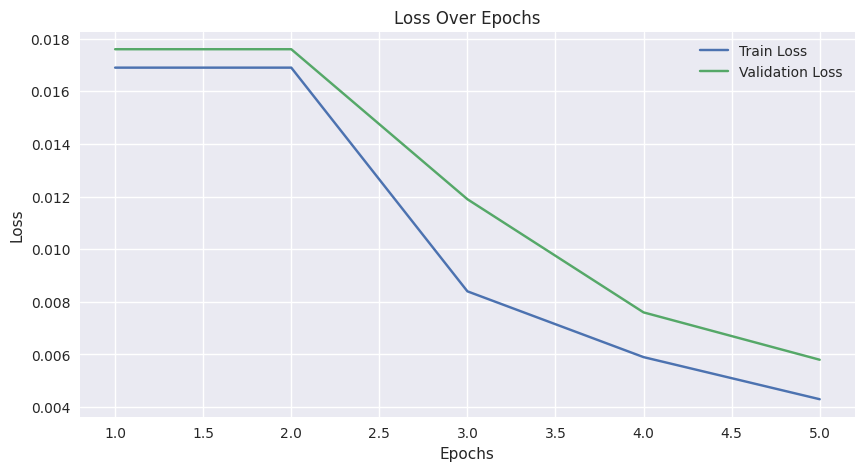

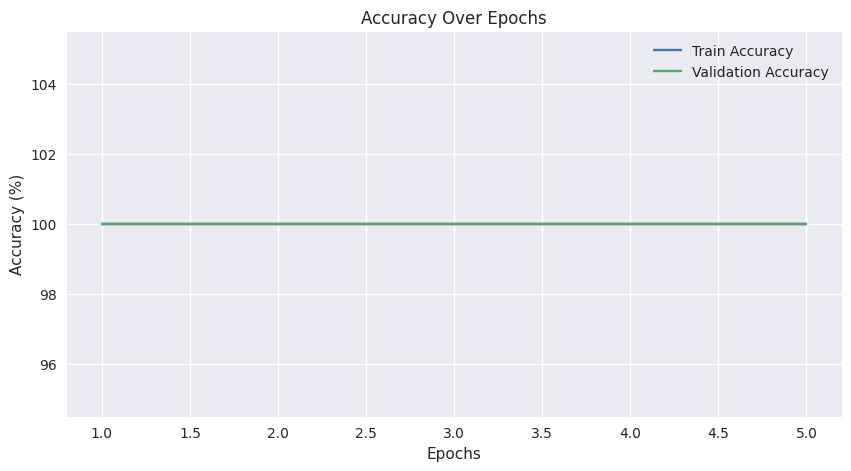

In [ ]:
def parse_metrics(file_path):
    metrics = []
    with open(file_path, 'r') as f:
        for line in f:
            match = re.match(r"epoch:(\d+), "
                             r"trainLoss:\s([\d\.]+), "
                             r"valLoss:\s([\d\.]+), "
                             r"trainAccuracy:\s([\d\.]+)%, "
                             r"valAccuracy:\s([\d\.]+)%, "
                             r"trainConfusionMatrix:\s\[\[(.*)\]\], "
                             r"valConfusionMatrix:\s\[\[(.*)\]\]", line)
            if match:
                epoch = int(match.group(1))
                train_loss = float(match.group(2))
                val_loss = float(match.group(3))
                train_acc = float(match.group(4))
                val_acc = float(match.group(5))
                train_conf_matrix = [list(map(float, row.split(','))) for row in match.group(6).split('], [')]
                val_conf_matrix = [list(map(float, row.split(','))) for row in match.group(7).split('], [')]
                
                metrics.append({
                    'epoch': epoch,
                    'trainLoss': train_loss,
                    'valLoss': val_loss,
                    'trainAccuracy': train_acc,
                    'valAccuracy': val_acc,
                    'trainConfusionMatrix': train_conf_matrix,
                    'valConfusionMatrix': val_conf_matrix
                })
            else:
                print(f"Line not matched: {line}")
    return metrics

metrics = parse_metrics('training_metrics_emer.txt')

epochs = [m['epoch'] for m in metrics]
train_loss = [m['trainLoss'] for m in metrics]
val_loss = [m['valLoss'] for m in metrics]
train_acc = [m['trainAccuracy'] for m in metrics]
val_acc = [m['valAccuracy'] for m in metrics]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

### Confusion Matrix

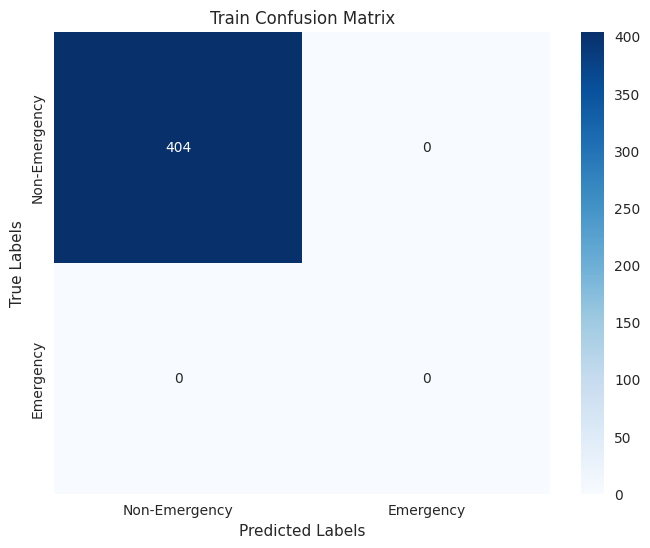

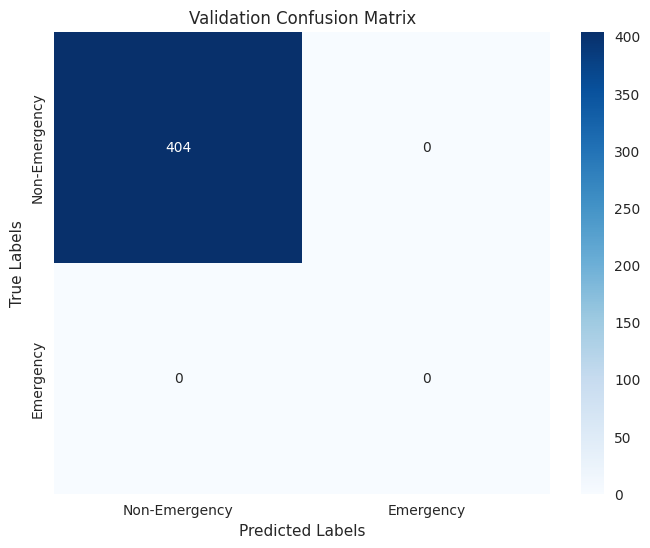

In [59]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    cm = cm.astype(int)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

metrics = parse_metrics('training_metrics_emer.txt')

train_cm = np.array(metrics[-1]['trainConfusionMatrix'])
val_cm = np.array(metrics[-1]['valConfusionMatrix'])

plot_confusion_matrix(train_cm, class_names=CLASS_NAME, title='Train Confusion Matrix')
plot_confusion_matrix(val_cm, class_names=CLASS_NAME, title='Validation Confusion Matrix')
